# How to use language model to do text classification?

1. Set a pipeline for doing text classification using llm
2. Set LORA for fine-tuning the llm

## Dependencies

In [1]:
# BASICS
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm

# DATA
from data.process_data import load_train_data, load_test_data, load_data
from torch.utils.data import Dataset, DataLoader

# Model
import torch
import torch.nn as nn
from transformers import pipeline
from transformers import AutoModelForCausalLM, AutoTokenizer, AdamW
from peft import LoraConfig, get_peft_model

# EVALUATIONS
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
# helper function
def plot_cm(y_test, y_test_pred, name, labels=[1, 2, 3, 4, 5]):
    # plot confusion matrix
    
    # modify those two lists back into 1, 0
    y_test = (np.array(y_test) == 3082)*1
    y_test_pred = (y_test_pred == 3082)*1
    
    cm = confusion_matrix(y_test, y_test_pred)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm_df, annot=True, cmap=plt.get_cmap('Blues'), fmt="d")
    plt.title("Confusion Matrix of " + name)
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

## Load Data

In [3]:
%%time
X_train, X_test, y_train, y_test = load_data()

CPU times: user 2min 19s, sys: 540 ms, total: 2min 20s
Wall time: 2min 20s


In [4]:
model_id = "meta-llama/Llama-3.2-1B-Instruct" # this will requires permit
device = torch.device('cuda')

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(model_id,
                                            torch_dtype=torch.bfloat16).to(device)

In [5]:
prompt_template = "The following comment is toxic, true or false:\n\nComment: {comment}\nAnswer:"

In [6]:
new_y_train = [3082 if elem else 3641 for elem in y_train]
new_y_test = [3082 if elem else 3641 for elem in y_test]
new_X_train = [prompt_template.format(comment=sentence) for sentence in X_train]
new_X_test = [prompt_template.format(comment=sentence) for sentence in X_test]

In [7]:
class Toxic_dataset(Dataset):
    def __init__(self, X, y):

        self.labels = torch.tensor(y, dtype=torch.long)

        self.sentences = X

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sentences[idx], self.labels[idx]

In [8]:
train_dataset = Toxic_dataset(new_X_train, new_y_train)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataset = Toxic_dataset(new_X_test, new_y_test)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Evaluate Before Training

The method is not perfect...
We are checking if the model is printing out True or False

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
def make_predictions(model, loader):
    model.eval()
    y_test_pred = []

    with torch.no_grad():
        for X, y in tqdm(loader):
            y = y.to(device)
            
            input_ids = tokenizer(X, return_tensors='pt')['input_ids'].to(device)
            out = model(input_ids).logits[:,-1,:]
            pred = out.argmax()
            y_test_pred.append(pred.cpu().numpy())
            
    return np.array(y_test_pred)

In [10]:
%%time
y_train_pred = make_predictions(model, train_dataloader)
y_test_pred = make_predictions(model, test_dataloader)  

100%|███████████████████████████████████████| 2886/2886 [01:09<00:00, 41.29it/s]

CPU times: user 11min 46s, sys: 2.77 s, total: 11min 49s
Wall time: 11min 46s


In [11]:
# train acc
accuracy_score(new_y_train, y_train_pred)

0.37499037499037496

In [12]:
# test acc
accuracy_score(new_y_test, y_test_pred)

0.3665973665973666

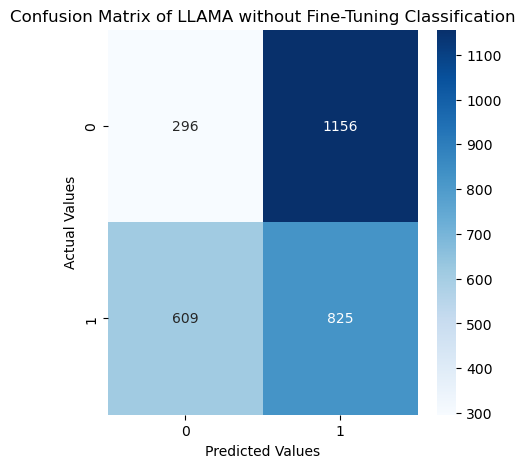

In [13]:
plot_cm(new_y_test, y_test_pred, "LLAMA without Fine-Tuning Classification", [0, 1])

## Train the model using LORA

In [14]:
lora_config = LoraConfig(
    r=64,  # Rank of the low-rank matrix
    lora_alpha=32,  # Scaling factor
    target_modules=["q_proj", "v_proj"],  # Which modules to apply LoRA
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",  # Task type
)
lora_model = get_peft_model(model, lora_config)
lora_model.print_trainable_parameters()

trainable params: 6,815,744 || all params: 1,242,630,144 || trainable%: 0.5485


In [15]:
# Training function
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss().to(device)
def train_epoch(data_loader, model, optimizer):
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    model.train()
    train_loss, correct = 0, 0
    step_count = 0
    for X, y in tqdm(data_loader):
        y = y.to(device)
        
        input_ids = tokenizer(X, return_tensors='pt')['input_ids'].to(device)
        out = model(input_ids).logits[:,-1,:]
        
        loss = criterion(out, y)
        train_loss += loss.item()
        pred = out.argmax()
        correct += (pred == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_train_loss = train_loss / num_batches
    accuracy = correct / size
    return accuracy, average_train_loss

def eval_epoch(data_loader, model, optimizer):
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    model.eval()
    eval_loss = 0
    correct = 0
    for X, y in tqdm(data_loader):
        y = y.to(device)
        input_ids = tokenizer(X, return_tensors='pt')['input_ids'].to(device)
        out = model(input_ids).logits[:,-1,:]
        
        loss = criterion(out, y)
        eval_loss += loss.item()
        pred = out.argmax()
        correct += (pred == y).type(torch.float).sum().item()

    average_eval_loss = eval_loss / num_batches
    accuracy = correct / size
    return accuracy, average_eval_loss

In [16]:
# for epoch in tqdm(range(2)):
train_accuracy, train_loss = train_epoch(train_dataloader, lora_model, optimizer)

print(f'train accuracy {train_accuracy:.3f}')

100%|█████████████████████████████████████| 25974/25974 [42:22<00:00, 10.22it/s]

train accuracy 0.931


## Re-Evaluate After Fine-Tuning with LoRA

In [17]:
%%time
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
y_train_pred = make_predictions(lora_model, train_dataloader)
y_test_pred = make_predictions(lora_model, test_dataloader)  

100%|███████████████████████████████████████| 2886/2886 [01:27<00:00, 33.14it/s]

CPU times: user 13min 57s, sys: 2.48 s, total: 14min
Wall time: 13min 58s


In [18]:
# train acc
accuracy_score(new_y_train, y_train_pred)

0.9556864556864557

In [19]:
# test acc
accuracy_score(new_y_test, y_test_pred)

0.9494109494109494

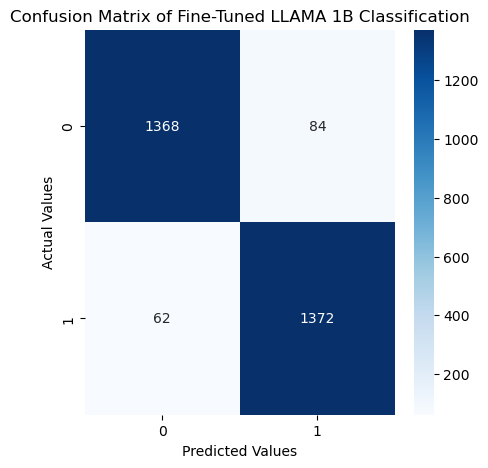

In [20]:
plot_cm(new_y_test, y_test_pred, "Fine-Tuned LLAMA 1B Classification", [0, 1])

## Error Analysis

In [46]:
false_preds_X = X_test[new_y_test != y_test_pred]
false_y = y_test[new_y_test != y_test_pred]
false_y_pred = y_test_pred[new_y_test != y_test_pred]

In [68]:
false_preds[7]

'I LOVE MUDKIPS! MOAR MUDKIPS!'

In [73]:
false_y[7]

0

In [71]:
tokenizer.decode(false_y_pred[7])

' True'

In [72]:
false_preds[2]

'Make that four, fifth is underway.  This is rediculous!   18:32, 29 Dec 2004 (UTC)'

In [74]:
false_y[2]

1

In [75]:
tokenizer.decode(false_y_pred[2])

' False'